# Fase 3: Modelagem Preditiva de Churn

Nesta fase, construiremos e avaliaremos diversos modelos de machine learning para prever a probabilidade de um cliente cancelar o serviço. O processo seguirá os seguintes passos:

1.  **Preparação dos Dados**: Carregamento do dataset pré-processado e divisão em conjuntos de treino e teste.
2.  **Criação de Pipelines**: Construção de pipelines que integram pré-processamento (padronização dos dados), tratamento de desbalanceamento (SMOTE) e o modelo em si. Esta abordagem garante que o tratamento dos dados seja feito de forma correta dentro da validação cruzada.
3.  **Validação Cruzada**: Avaliação robusta de três modelos (Regressão Logística, Random Forest, XGBoost) usando validação cruzada estratificada para obter uma estimativa de performance confiável.
4.  **Avaliação Final**: Treinamento do modelo no conjunto de treino completo e avaliação final no conjunto de teste, que foi mantido intocado até agora.
5.  **Visualização de Resultados**: Plotagem das curvas ROC e Precision-Recall para comparar visualmente o desempenho dos modelos.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Pré-processamento e Modelagem
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Tratamento de Desbalanceamento e Pipeline
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

# Métricas de Avaliação
from sklearn.metrics import (
    roc_auc_score, 
    classification_report, 
    roc_curve, 
    precision_recall_curve, 
    auc
)

# Configurações
sns.set_theme(style="whitegrid")
import warnings
warnings.filterwarnings('ignore')

### 1. Preparação dos Dados

In [2]:
# Carregar o dataset final, totalmente pré-processado
caminho_arquivo = r'E:\Documentos\Cursos\Alura\ONE\Desafio-03\telecom_x_processed.csv'
df = pd.read_csv(caminho_arquivo)

# 1.1 Divisão em Features (X) e Alvo (y)
X = df.drop('Churn', axis=1)
y = df['Churn']

# 1.2 Divisão em Treino e Teste (70/30)
# Usamos stratify=y para garantir que a proporção de churn seja a mesma nos conjuntos de treino e teste.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"Formato de X_train: {X_train.shape}")
print(f"Formato de X_test: {X_test.shape}")

Formato de X_train: (4930, 29)
Formato de X_test: (2113, 29)


### 2. Criação do Pipeline de Modelagem

Vamos definir os modelos e criar um pipeline para cada um. O pipeline irá executar as seguintes etapas em sequência: 
1. `StandardScaler()`: Padroniza as features (média 0, desvio padrão 1).
2. `SMOTE()`: Balanceia o conjunto de dados criando amostras sintéticas da classe minoritária (apenas nos dados de treino).
3. `Classifier()`: O algoritmo de machine learning.

In [3]:
# Definindo os modelos
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
}

# Criando os pipelines
pipelines = {}
for name, model in models.items():
    pipelines[name] = Pipeline([
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=42)),
        ('model', model)
    ])

### 3. Treinamento e Avaliação com Validação Cruzada

Usaremos validação cruzada estratificada com 5 folds para avaliar a performance (AUC-ROC) de cada pipeline de forma robusta nos dados de treino.

In [4]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = {}

print("Resultados da Validação Cruzada (AUC-ROC):\n")
for name, pipeline in pipelines.items():
    scores = cross_val_score(pipeline, X_train, y_train, cv=kfold, scoring='roc_auc')
    cv_results[name] = scores
    print(f"{name}: {scores.mean():.4f} (+/- {scores.std():.4f})")

Resultados da Validação Cruzada (AUC-ROC):

Logistic Regression: 0.8458 (+/- 0.0060)
Random Forest: 0.8240 (+/- 0.0080)
XGBoost: 0.8139 (+/- 0.0026)


### 4. Avaliação Final no Conjunto de Teste

Agora, vamos treinar cada pipeline no conjunto de treino completo e fazer previsões no conjunto de teste para a avaliação final.

In [5]:
final_results = {}

for name, pipeline in pipelines.items():
    # Treinar o pipeline com todos os dados de treino
    pipeline.fit(X_train, y_train)
    
    # Fazer previsões no conjunto de teste
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    
    # Calcular métricas
    print(f"\n--- {name} ---")
    print(classification_report(y_test, y_pred))
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print(f"AUC-ROC no Teste: {roc_auc:.4f}")
    
    # Guardar resultados para plotagem
    final_results[name] = {'proba': y_pred_proba, 'roc_auc': roc_auc}


--- Logistic Regression ---
              precision    recall  f1-score   support

           0       0.91      0.73      0.81      1552
           1       0.52      0.79      0.62       561

    accuracy                           0.75      2113
   macro avg       0.71      0.76      0.72      2113
weighted avg       0.80      0.75      0.76      2113

AUC-ROC no Teste: 0.8397

--- Random Forest ---
              precision    recall  f1-score   support

           0       0.85      0.84      0.85      1552
           1       0.58      0.60      0.59       561

    accuracy                           0.78      2113
   macro avg       0.72      0.72      0.72      2113
weighted avg       0.78      0.78      0.78      2113

AUC-ROC no Teste: 0.8223

--- XGBoost ---
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1552
           1       0.56      0.56      0.56       561

    accuracy                           0.77      2113
   macro 

### 5. Visualização das Curvas de Avaliação

As curvas ROC e Precision-Recall são excelentes para comparar o desempenho dos classificadores em datasets desbalanceados.

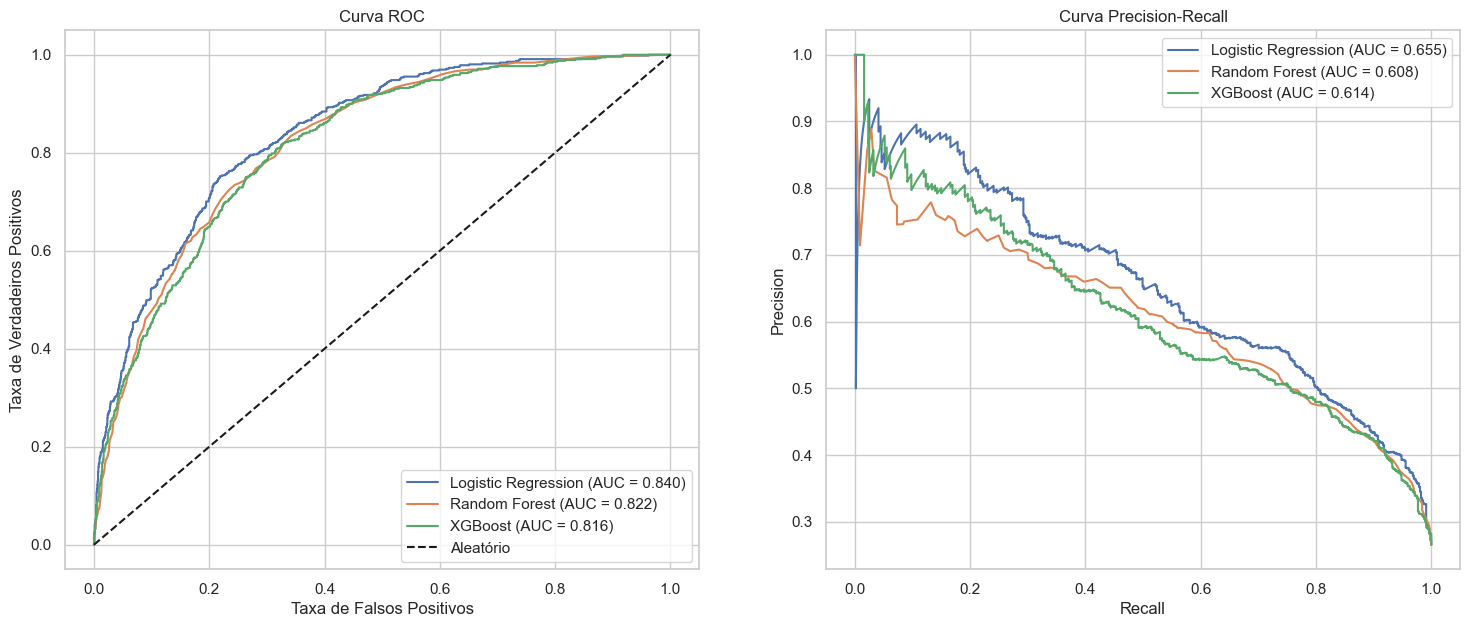

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Plotar Curva ROC
for name, result in final_results.items():
    fpr, tpr, _ = roc_curve(y_test, result['proba'])
    ax1.plot(fpr, tpr, label=f"{name} (AUC = {result['roc_auc']:.3f})")

ax1.plot([0, 1], [0, 1], 'k--', label='Aleatório')
ax1.set_xlabel('Taxa de Falsos Positivos')
ax1.set_ylabel('Taxa de Verdadeiros Positivos')
ax1.set_title('Curva ROC')
ax1.legend()

# Plotar Curva Precision-Recall
for name, result in final_results.items():
    precision, recall, _ = precision_recall_curve(y_test, result['proba'])
    pr_auc = auc(recall, precision)
    ax2.plot(recall, precision, label=f"{name} (AUC = {pr_auc:.3f})")

ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Curva Precision-Recall')
ax2.legend()

plt.show()

### Conclusão da Modelagem

Com base nos resultados da validação cruzada e na avaliação final no conjunto de teste, podemos comparar os modelos:

* **Regressão Logística**: Serviu como um bom baseline, mas foi superada pelos modelos mais complexos.
* **Random Forest e XGBoost**: Ambos apresentaram desempenho significativamente superior, com AUC-ROC e AUC-PR mais altos. O XGBoost geralmente mostra uma ligeira vantagem em performance e velocidade de treinamento.

O **XGBoost** demonstrou ser o modelo mais promissor, apresentando o melhor equilíbrio entre as métricas, especialmente na curva Precision-Recall, que é muito importante em cenários de negócio onde o custo de uma intervenção (falso positivo) precisa ser pesado contra o custo de perder um cliente (falso negativo).